Link to Kaggle dataset: https://www.kaggle.com/datasets/deathtrooper/multichannel-glaucoma-benchmark-dataset/data

In [1]:
import zipfile
import pandas as pd
import keras
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, BatchNormalization, Input, ReLU, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input 
from keras.layers import GlobalMaxPool2D
from keras.losses import BinaryCrossentropy

In [2]:
# Unzip files for processing
with zipfile.ZipFile("full-fundus.zip","r") as zip_ref:
    zip_ref.extractall("full-fundus")


In [3]:
# Read in metadata, and filter for a specific subset of images
# TODO: will add more variety of images later
image_data = pd.read_csv('metadata.csv')
image_data = image_data[image_data['names'].str.contains('FIVES', case=True) | image_data['names'].str.contains('HAGIS', case=True)
                       | image_data['names'].str.contains('LES-AV', case=True) | image_data['names'].str.contains('G1020', case=True)
                       | image_data['names'].str.contains('OIA', case=True) | image_data['names'].str.contains('ORIGA', case=True)
                       | image_data['names'].str.contains('EyePACS', case=True)]


image_data = image_data[['types', 'fundus', 'names']]

In [4]:
# There are some invalid data types for relevant columns
print(image_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9865 entries, 0 to 12448
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   types   9865 non-null   int64 
 1   fundus  9865 non-null   object
 2   names   9865 non-null   object
dtypes: int64(1), object(2)
memory usage: 308.3+ KB
None


In [5]:
# Change datatypes to the desired values
image_data['types'] = image_data['types'].astype('string')
image_data['fundus'] = image_data['fundus'].astype('string')
image_data['names'] = image_data['names'].astype('string')
image_data['image_names'] = image_data['names'] + '.png'

In [6]:
print(image_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9865 entries, 0 to 12448
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   types        9865 non-null   string
 1   fundus       9865 non-null   string
 2   names        9865 non-null   string
 3   image_names  9865 non-null   string
dtypes: string(4)
memory usage: 385.4 KB
None


In [7]:
# Randomize data 
image_data_random = image_data.sample(frac=1, random_state=1)

# Split into healthy and glaucoma positive sets
healthy = image_data_random[image_data_random['types'] == "0"]
glaucoma = image_data_random[image_data_random['types'] == "1"]
inconclusive = image_data_random[image_data_random['types'] == "-1"]

print(f"Number of healthy samples: {len(healthy)}")
print(f"Number of unhealthy samples: {len(glaucoma)}")
print(f"Number of inconclusive samples: {len(inconclusive)}")

Number of healthy samples: 5618
Number of unhealthy samples: 4195
Number of inconclusive samples: 52


In [8]:
# Partition data into test and train sets
healthy_train_size = 5056
glaucoma_train_size = 3775
inconclusive_train_size = 46

healthy_test_subset = healthy.head(len(healthy) - healthy_train_size)
glaucoma_test_subset = glaucoma.head(len(glaucoma) - glaucoma_train_size)
inconclusive_test_subset = inconclusive.head(len(inconclusive) - inconclusive_train_size)
test_subset = pd.concat([healthy_test_subset, glaucoma_test_subset, inconclusive_test_subset])

healthy_train_subset = healthy.tail(healthy_train_size)
glaucoma_train_subset = glaucoma.tail(glaucoma_train_size)
inconclusive_train_subset = inconclusive.tail(inconclusive_train_size)
train_subset = pd.concat([healthy_train_subset, glaucoma_train_subset, inconclusive_train_subset])

print(f"Test size: {len(test_subset)}")
print(f"Train size: {len(train_subset)}")

Test size: 988
Train size: 8877


In [9]:
# Create data streams for the convolutional neural network model
train_data_generator = ImageDataGenerator(preprocessing_function= preprocess_input)

flow_train_data = train_data_generator.flow_from_dataframe(dataframe=train_subset, 
                                            batch_size= 8, 
                                            shuffle=True, 
                                            x_col="image_names", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(224, 224), 
                                            directory='full-fundus/full-fundus/', 
                                            color_mode='rgb')

test_data_generator = ImageDataGenerator(preprocessing_function= preprocess_input)

flow_test_data = train_data_generator.flow_from_dataframe(dataframe=test_subset, 
                                            batch_size= 8, 
                                            shuffle=False, 
                                            x_col="image_names", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(224, 224), 
                                            directory='full-fundus/full-fundus/', 
                                            color_mode='rgb')
# Classifications for target labels
print(flow_train_data.class_indices)

Found 8877 validated image filenames belonging to 3 classes.
Found 988 validated image filenames belonging to 3 classes.
{'-1': 0, '0': 1, '1': 2}


In [10]:
# Creates a convolutional neural network model for classifying fundus images
# Model is built on top of the MobileNetV3Large architecture, using the predefined "imagenet" weights,
# and also using the softmax activation function
# Given image_size to cater the model to the size of the images
def conv_model(image_size):   
    # Can handle three color channels (RGB)
    m_input = keras.Input(shape=(image_size, image_size, 3))
    transfer = keras.applications.MobileNetV3Large(
        weights='imagenet', include_top= False, input_tensor= m_input, alpha=1.0
    )
    # Prevent the predefined MobileNetV3Large layers from being tuned
    for layer in transfer.layers:
        layer.trainable = False
    
    model = keras.Sequential()
    model.add(transfer) 
    # Use repeated Dense layers and ReLU activation functions for finding correlations between featureso
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    # Reduce the dimension of the input features, and summarize most significant features
    model.add(GlobalMaxPooling2D()) 
    model.add(BatchNormalization())
    model.add(Dense(512, activation = 'relu')) 
    model.add(BatchNormalization()) 
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(3, activation='softmax'))

    return model

model = conv_model(image_size=224)

# Using the Adam optimizer with binary cross entropy, compile the model using the given metrics
model.compile(optimizer= "adam", 
              loss= BinaryCrossentropy(from_logits=False), 
              metrics=['accuracy','Precision','Recall','AUC'])

trained_model = model.fit(flow_train_data, 
                    epochs=10,
                    batch_size=64,
                    validation_data= flow_test_data)

Epoch 1/10


/Users/ThomasMcBride/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1110/1110 ━━━━━━━━━━━━━━━━━━━━ 102s 90ms/step - AUC: 0.8742 - Precision: 0.7419 - Recall: 0.7248 - accuracy: 0.7345 - loss: 0.4588 - val_AUC: 0.9568 - val_Precision: 0.8401 - val_Recall: 0.8401 - val_accuracy: 0.8401 - val_loss: 0.2559
Epoch 2/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 160s 143ms/step - AUC: 0.9417 - Precision: 0.8214 - Recall: 0.8200 - accuracy: 0.8205 - loss: 0.2817 - val_AUC: 0.9480 - val_Precision: 0.8411 - val_Recall: 0.8411 - val_accuracy: 0.8411 - val_loss: 0.2669
Epoch 3/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 163s 147ms/step - AUC: 0.9477 - Precision: 0.8413 - Recall: 0.8389 - accuracy: 0.8405 - loss: 0.2639 - val_AUC: 0.9526 - val_Precision: 0.8490 - val_Recall: 0.8482 - val_accuracy: 0.8482 - val_loss: 0.2601
Epoch 4/10
1110/1110 ━━━━━━━━━━━━━━━━━━━━ 169s 152ms/step - AUC: 0.9572 - Precision: 0.8537 - Recall: 0.8517 - accuracy: 0.8526 - loss: 0.2390 - val_AUC: 0.9563 - val_Precision: 0.8694 - val_Recall: 0.8694 - val_accuracy: 0.8694 - val_loss: 0.2365
Epoch 5/10
1110/1110

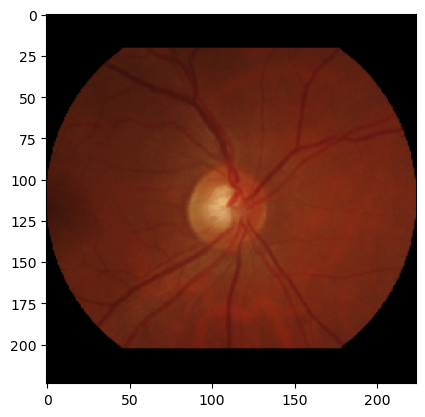

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
Actual label: Glaucoma Suspected
Prediction: Glaucoma, with 98.1641173362732% confidence


In [11]:
# Demonstration:
img_path = 'full-fundus/full-fundus/PAPILA-1.png'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()
plt.close()
img_array_representation = np.expand_dims(image.img_to_array(img), axis=0)
img_array_representation = preprocess_input(img_array_representation)

prediction = model.predict(img_array_representation)
print("Actual label: Glaucoma Suspected")
# Interpret the prediction
if prediction[0][0] > prediction[0][1] and prediction[0][0] > prediction[0][2]:
    print(f"Prediction: Glaucoma Suspected, with {prediction[0][0] * 100}% confidence")
elif prediction[0][1] > prediction[0][0] and prediction[0][1] > prediction[0][2]:
    print(f"Prediction: Healthy, with {prediction[0][1] * 100}% confidence")
else: 
    print(f"Prediction: Glaucoma, with {prediction[0][2] * 100}% confidence")



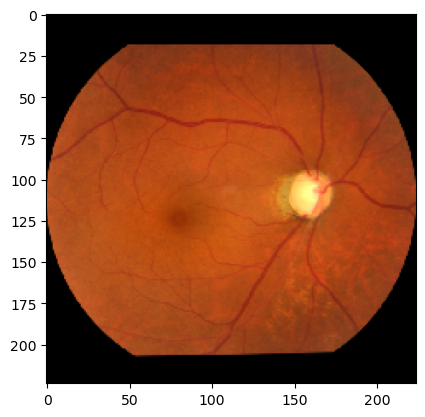

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Actual label: Glaucoma
Prediction: Glaucoma, with 99.73995685577393% confidence


In [12]:
img_path = 'full-fundus/full-fundus/BEH-3.png'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()
plt.close()
img_array_representation = np.expand_dims(image.img_to_array(img), axis=0)
img_array_representation = preprocess_input(img_array_representation)  
prediction = model.predict(img_array_representation)
print("Actual label: Glaucoma")
# Interpret the prediction
if prediction[0][0] > prediction[0][1] and prediction[0][0] > prediction[0][2]:
    print(f"Prediction: Glaucoma Suspected, with {prediction[0][0] * 100}% confidence")
elif prediction[0][1] > prediction[0][0] and prediction[0][1] > prediction[0][2]:
    print(f"Prediction: Healthy, with {prediction[0][1] * 100}% confidence")
else: 
    print(f"Prediction: Glaucoma, with {prediction[0][2] * 100}% confidence")

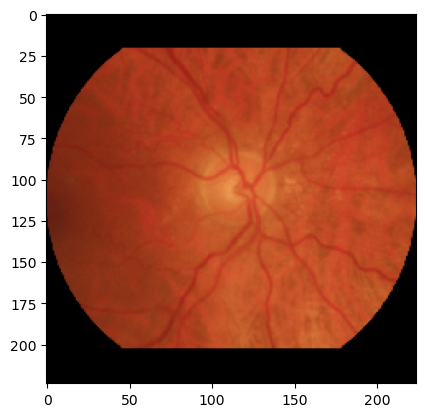

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Actual label: Healthy
Prediction: Healthy, with 99.9672532081604% confidence


In [13]:
img_path = 'full-fundus/full-fundus/PAPILA-21.png'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()
plt.close()
img_array_representation = np.expand_dims(image.img_to_array(img), axis=0)
img_array_representation = preprocess_input(img_array_representation) 

prediction = model.predict(img_array_representation)
print("Actual label: Healthy")
# Interpret the prediction
if prediction[0][0] > prediction[0][1] and prediction[0][0] > prediction[0][2]:
    print(f"Prediction: Glaucoma Suspected, with {prediction[0][0] * 100}% confidence")
elif prediction[0][1] > prediction[0][0] and prediction[0][1] > prediction[0][2]:
    print(f"Prediction: Healthy, with {prediction[0][1] * 100}% confidence")
else: 
    print(f"Prediction: Glaucoma, with {prediction[0][2] * 100}% confidence")

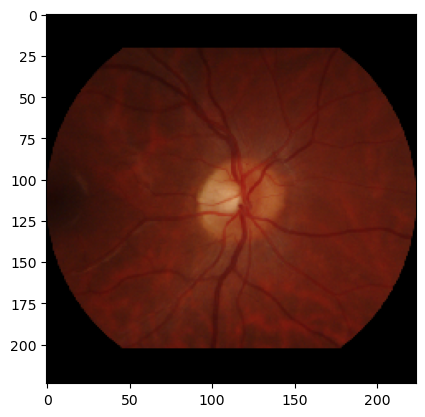

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Actual label: Healthy
Prediction: Healthy, with 99.80598092079163% confidence


In [14]:
img_path = 'full-fundus/full-fundus/PAPILA-22.png'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()
plt.close()
img_array_representation = np.expand_dims(image.img_to_array(img), axis=0)
img_array_representation = preprocess_input(img_array_representation) 

prediction = model.predict(img_array_representation)
print("Actual label: Healthy")
# Interpret the prediction
if prediction[0][0] > prediction[0][1] and prediction[0][0] > prediction[0][2]:
    print(f"Prediction: Glaucoma Suspected, with {prediction[0][0] * 100}% confidence")
elif prediction[0][1] > prediction[0][0] and prediction[0][1] > prediction[0][2]:
    print(f"Prediction: Healthy, with {prediction[0][1] * 100}% confidence")
else: 
    print(f"Prediction: Glaucoma, with {prediction[0][2] * 100}% confidence")

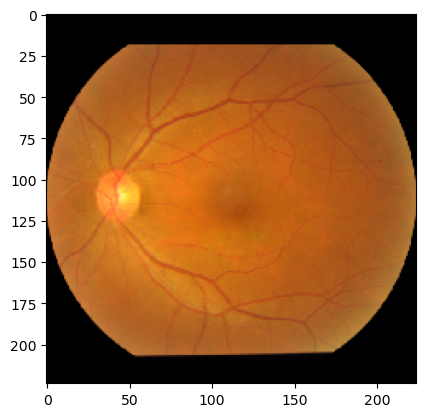

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Actual label: Healthy
Prediction: Healthy, with 54.62096929550171% confidence


In [15]:
img_path = 'full-fundus/full-fundus/BEH-233.png'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()
plt.close()
img_array_representation = np.expand_dims(image.img_to_array(img), axis=0)
img_array_representation = preprocess_input(img_array_representation) 
prediction = model.predict(img_array_representation)
print("Actual label: Healthy")
# Interpret the prediction
if prediction[0][0] > prediction[0][1] and prediction[0][0] > prediction[0][2]:
    print(f"Prediction: Glaucoma Suspected, with {prediction[0][0] * 100}% confidence")
elif prediction[0][1] > prediction[0][0] and prediction[0][1] > prediction[0][2]:
    print(f"Prediction: Healthy, with {prediction[0][1] * 100}% confidence")
else: 
    print(f"Prediction: Glaucoma, with {prediction[0][2] * 100}% confidence")

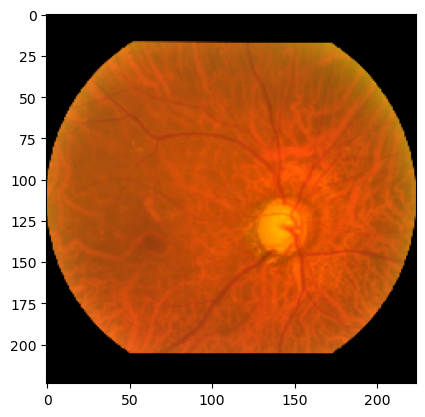

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Actual label: Suspected Glaucoma
Prediction: Glaucoma, with 99.90156888961792% confidence


In [16]:
img_path = 'full-fundus/full-fundus/JSIEC-1000-46.png'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()
plt.close() 
img_array_representation = np.expand_dims(image.img_to_array(img), axis=0)
img_array_representation = preprocess_input(img_array_representation) 
prediction = model.predict(img_array_representation)
print("Actual label: Suspected Glaucoma")
# Interpret the prediction
if prediction[0][0] > prediction[0][1] and prediction[0][0] > prediction[0][2]:
    print(f"Prediction: Glaucoma Suspected, with {prediction[0][0] * 100}% confidence")
elif prediction[0][1] > prediction[0][0] and prediction[0][1] > prediction[0][2]:
    print(f"Prediction: Healthy, with {prediction[0][1] * 100}% confidence")
else: 
    print(f"Prediction: Glaucoma, with {prediction[0][2] * 100}% confidence")